# Trabajo práctico - Procesamiento de datos, análisis exploratorio y modelos regresivos

Este trabajo es una adaptación al que se dió en la materia Laboratorio de Datos del Instituto de Cálculo de la FCEN, UBA, en el 1er cuatrimestre de 2024.

En este, se desarrollarán técnicas para el procesamiento de un conjunto de datos, su limpieza, el análisis de sus características, y la creación de modelos regresivos para estimar alguna de sus variables numéricas.

Importamos los paquetes que utilizaremos a lo largo de este trabajo.

In [ ]:
import numpy as nps
import pandas as pd
import seaborn.objects as so
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from formulaic import Formula


Utilizando la librería $\emph{pandas}$, cargamos el dataset como un DataFrame y lo visualizamos.

In [9]:
sube = pd.read_csv('data/sube-2024.csv')
sube.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR
0,2024-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,175,NO
1,2024-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,14,NO
2,2024-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1811,NO
3,2024-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 720M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,576,NO
4,2024-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,264,NO


También podemos ver información general:

In [10]:
sube.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504676 entries, 0 to 504675
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DIA_TRANSPORTE   504676 non-null  object
 1   NOMBRE_EMPRESA   504676 non-null  object
 2   LINEA            504676 non-null  object
 3   AMBA             504676 non-null  object
 4   TIPO_TRANSPORTE  504676 non-null  object
 5   JURISDICCION     502154 non-null  object
 6   PROVINCIA        502139 non-null  object
 7   MUNICIPIO        502139 non-null  object
 8   CANTIDAD         504676 non-null  int64 
 9   DATO_PRELIMINAR  504676 non-null  object
dtypes: int64(1), object(9)
memory usage: 38.5+ MB


## Procesamiento de datos

### Ejercicio 1

$\mathbf{(a)}$ Visualizar el tipo de datos de cada columna. Transformar la columna DIA_TRANSPORTE para que sea reconocida como una fecha

Primero, visualizamos el tipo de datos de cada columna del dataframe usando el atributo dtypes:

In [11]:
sube.dtypes

DIA_TRANSPORTE     object
NOMBRE_EMPRESA     object
LINEA              object
AMBA               object
TIPO_TRANSPORTE    object
JURISDICCION       object
PROVINCIA          object
MUNICIPIO          object
CANTIDAD            int64
DATO_PRELIMINAR    object
dtype: object

Para que la columna DIA_TRANSPORTE sea reconocida como fecha, usaremos la función to_datetime de pandas

In [12]:
sube['DIA_TRANSPORTE'] = pd.to_datetime(sube['DIA_TRANSPORTE'], format = "%Y-%m-%d")

De esta forma, si volvemos a chequear el tipo de dato de la columna DIA_TRANSPORTE, obtenemos lo siguiente:

In [13]:
sube.dtypes

DIA_TRANSPORTE     datetime64[ns]
NOMBRE_EMPRESA             object
LINEA                      object
AMBA                       object
TIPO_TRANSPORTE            object
JURISDICCION               object
PROVINCIA                  object
MUNICIPIO                  object
CANTIDAD                    int64
DATO_PRELIMINAR            object
dtype: object

$\mathbf{(b)}$ Agregar tres columnas al DataFrame:

- FECHA_DIA: debe indicar el nombre del día de la semana correspondiente a DIA_TRANSPORTE
- FECHA_ORDINAL: debe indicar el ordinal correspondiente a DIA_TRANSPORTE (Por ejemplo, a 2024-01-01 le corresponde 1)
- FECHA_MES: debe indicar el mes correspondiente a DIA_TRANSPORTE

Para la primera columna, utilizamos la función day_name del grupo de propiedades dt de pandas:

In [14]:
sube['FECHA_DIA'] = sube['DIA_TRANSPORTE'].dt.day_name()
sube['FECHA_DIA']

0          Monday
1          Monday
2          Monday
3          Monday
4          Monday
           ...   
504671    Tuesday
504672    Tuesday
504673    Tuesday
504674    Tuesday
504675    Tuesday
Name: FECHA_DIA, Length: 504676, dtype: object

Para la columna FECHA_ORDINAL, usaremos el atributo dayofyear:

In [15]:
sube['FECHA_ORDINAL'] = sube['DIA_TRANSPORTE'].dt.dayofyear
sube['FECHA_ORDINAL']

0           1
1           1
2           1
3           1
4           1
         ... 
504671    366
504672    366
504673    366
504674    366
504675    366
Name: FECHA_ORDINAL, Length: 504676, dtype: int32

Por último, para la última columna utilizaremos el método apply de DataFrame.

In [16]:
sube['FECHA_MES'] = sube['DIA_TRANSPORTE'].dt.month.apply(lambda x: str(x).zfill(2))
sube['FECHA_MES']

0         01
1         01
2         01
3         01
4         01
          ..
504671    12
504672    12
504673    12
504674    12
504675    12
Name: FECHA_MES, Length: 504676, dtype: object

### Ejercicio 2

Crear el DataFrame datos_amba, el cuál sólo debe tener datos de AMBA y debe excluir datos preliminares.

Primero, nos quedamos con los registros que correspondan al AMBA, y reseteamos los índices

In [17]:
datos_amba = sube[sube['AMBA'] == 'SI'].reset_index(drop = True)

Ahora vamos a excluir la columna DATO_PRELIMINAR, y le vamos a dar un formato más sencillo al DataFrame:

In [18]:
datos_amba.columns = datos_amba.columns.str.lower() #Ponemos todos los títulos en minúscula
#Eliminamos las variables que no vamos a usar
datos_amba.drop(columns = ['dato_preliminar','nombre_empresa','municipio','amba','provincia'], inplace = True)
#Renombramos dos columnas
datos_amba = datos_amba.rename(columns = {'dia_transporte' : 'fecha','cantidad':'pasajeros'})
#Definimos un nuevo orden para las columnas y lo actualizamos
nuevo_orden = ['fecha','fecha_dia','fecha_mes','fecha_ordinal','jurisdiccion','linea','pasajeros','tipo_transporte']
datos_amba = datos_amba.reindex(columns=nuevo_orden)
#Abreviamos el día
datos_amba['fecha_dia'] = datos_amba['fecha_dia'].str.slice(0, 3)

In [19]:
datos_amba.head()

,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2024-01-01,Mon,01,1,MUNICIPAL,1,175,COLECTIVO
1,2024-01-01,Mon,01,1,MUNICIPAL,2B,14,COLECTIVO
2,2024-01-01,Mon,01,1,PROVINCIAL,BS_AS_LINEA_326,264,COLECTIVO
3,2024-01-01,Mon,01,1,MUNICIPAL,BS_AS_LINEA_522,145,COLECTIVO
4,2024-01-01,Mon,01,1,MUNICIPAL,BS_AS_LINEA_527,485,COLECTIVO


### Ejercicio 3

Utilizando datos_amba, identificar:

$\mathbf{(a)}$ La proporción de la cantidad total anual de pasajeros que le corresponde a cada medio de transporte

¿Qué medios de transporte tenemos en el DataFrame?

In [20]:
datos_amba['tipo_transporte'].unique()

array(['COLECTIVO', 'TREN', 'SUBTE'], dtype=object)

Veamos cuántos pasajeros hubo de cada uno:

In [21]:
pasajeros_colectivo = datos_amba.loc[datos_amba['tipo_transporte'] == 'COLECTIVO', 'pasajeros'].sum()
pasajeros_tren = datos_amba.loc[datos_amba['tipo_transporte'] == 'TREN', 'pasajeros'].sum()
pasajeros_subte = datos_amba.loc[datos_amba['tipo_transporte'] == 'SUBTE', 'pasajeros'].sum()

# Y la cantidad total de pasajeros:
total_pasajeros = datos_amba['pasajeros'].sum()

Obtenemos lo siguiente:

In [22]:
print('Porcentaje de pasajeros por tipo de transporte')
print(f'Colectivo: {round(pasajeros_colectivo/total_pasajeros * 100,2)}%')
print(f'Tren: {round(pasajeros_tren/total_pasajeros * 100,2)}%')
print(f'Subte: {round(pasajeros_subte/total_pasajeros * 100,2)}%')

Porcentaje de pasajeros por tipo de transporte
Colectivo: 84.03%
Tren: 9.81%
Subte: 6.16%


$\mathbf{(b)}$ La tupla (mes, línea de subte) donde viajó la mayor cantidad de pasajeros

Podemos resolver esta consulta en una sola línea:

In [23]:
datos_amba[datos_amba['tipo_transporte'] == 'SUBTE'].groupby(['fecha_mes','linea'])['pasajeros'].sum().idxmax()

('04', 'LINEA_B')

Explicación:
- Con el comando datos_amba[datos_amba['tipo_transporte'] == 'SUBTE'], nos quedamos únicamente con los registros que correspondan a los usos del subte.
- Agrupamos el DataFrame resultante en dos variables: Mes y Línea (groupby(['fecha_mes','linea']))
- Luego, tomamos la columna 'pasajeros' y le aplicamos la función sum(). Esto nos sumará la cantidad total de pasajeros agrupada por mes, y luego por línea de subte.
- Finalmente, nos quedamos con el índice que tenga el valor máximo, el cual corresponde al mes 4, y la línea B.

$\mathbf{(c)}$ El día hábil (i.e. cualquier día distinto de sábado y domingo) con menor desvío estándar en cantidad de pasajeros

Primero, creamos una variable de días hábiles:

In [24]:
dias_habiles = ["Mon", "Tue", "Wed", "Thu", "Fri"]

Y ahora calculamos el desvío estándar en cantidad de pasajeros para cada uno de ellos:

In [25]:
desvios_dias_habiles = [datos_amba[datos_amba['fecha_dia'] == d]['pasajeros'].std() for d in dias_habiles]

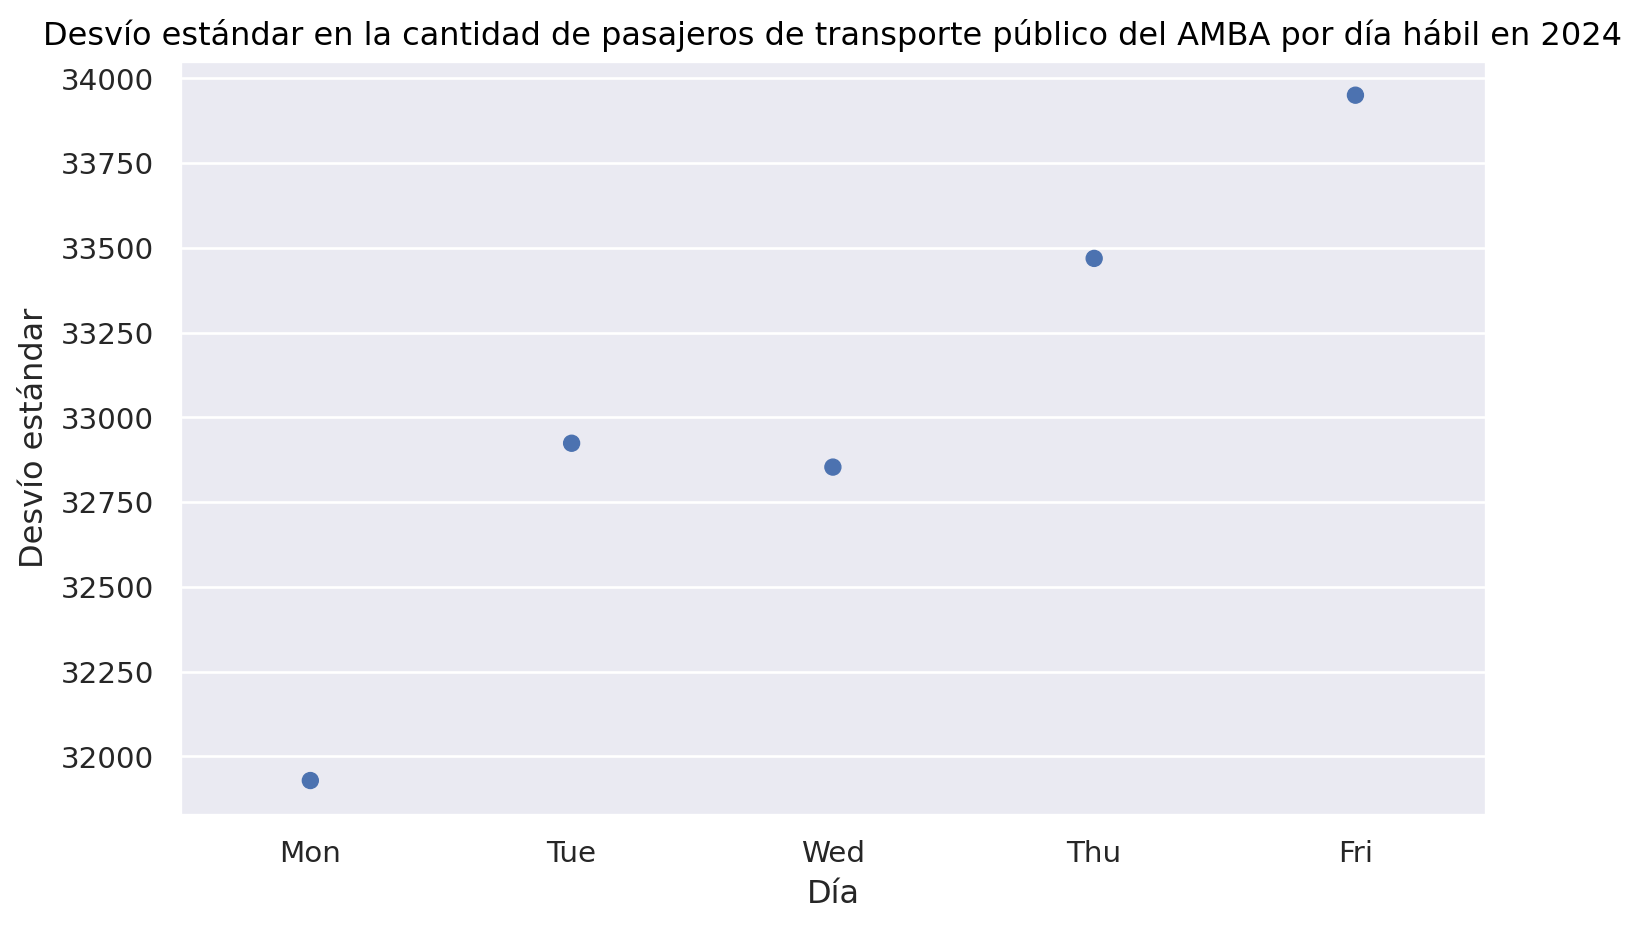

In [26]:
(
    so.Plot(x = dias_habiles, y = desvios_dias_habiles)
    .add(so.Dot())
    .label(x = 'Día', y = 'Desvío estándar', title = 'Desvío estándar en la cantidad de pasajeros de transporte público del AMBA por día hábil en 2024')
    .layout(size=(8,5))
)

Observamos que el día con menor desvío estándar en la cantidad de pasajeros es el lunes

##
***

## Análisis Exploratorio

### Ejercicio 4

En este apartado, analizaremos ciertas características de los datos con los que trabajamos

##### ¿Cómo cambió la actividad en el transporte público entre 2020 y 2024?

Tomemos los datos de cada año:

In [27]:
sube_2020 = pd.read_csv("data/sube-2020.csv")
sube_2021 = pd.read_csv("data/sube-2021.csv")
sube_2022 = pd.read_csv("data/sube-2022.csv")
sube_2023 = pd.read_csv("data/sube-2023.csv")
sube_2024 = pd.read_csv("data/sube-2024.csv")

Transformamos el tipo de dato de las columnas DIA_TRANSPORTE a formato fecha:

In [28]:
sube_2020["DIA_TRANSPORTE"] = pd.to_datetime(sube_2020["DIA_TRANSPORTE"], format = "%Y-%m-%d")
sube_2021["DIA_TRANSPORTE"] = pd.to_datetime(sube_2021["DIA_TRANSPORTE"], format = "%Y-%m-%d")
sube_2022["DIA_TRANSPORTE"] = pd.to_datetime(sube_2022["DIA_TRANSPORTE"], format = "%Y-%m-%d")
sube_2023["DIA_TRANSPORTE"] = pd.to_datetime(sube_2023["DIA_TRANSPORTE"], format = "%Y-%m-%d")
sube_2024["DIA_TRANSPORTE"] = pd.to_datetime(sube_2024["DIA_TRANSPORTE"], format = "%Y-%m-%d")

Ahora, nos gustaría tener la cantidad de pasajeros diarios para cada año:

In [29]:
cantidad_pasajeros_diarios_2020 = sube_2020.groupby(["DIA_TRANSPORTE"])["CANTIDAD"].sum()
cantidad_pasajeros_diarios_2021 = sube_2021.groupby(["DIA_TRANSPORTE"])["CANTIDAD"].sum()
cantidad_pasajeros_diarios_2022 = sube_2022.groupby(["DIA_TRANSPORTE"])["CANTIDAD"].sum()
cantidad_pasajeros_diarios_2023 = sube_2023.groupby(["DIA_TRANSPORTE"])["CANTIDAD"].sum()
cantidad_pasajeros_diarios_2024 = sube_2024.groupby(["DIA_TRANSPORTE"])["CANTIDAD"].sum()

Manejamos los índices para juntar estos datos en un DataFrame

In [30]:
cantidad_pasajeros_diarios_2020 = cantidad_pasajeros_diarios_2020.reset_index()
cantidad_pasajeros_diarios_2021 = cantidad_pasajeros_diarios_2021.reset_index().rename(index = lambda i: i + 366)
cantidad_pasajeros_diarios_2022 = cantidad_pasajeros_diarios_2022.reset_index().rename(index = lambda i: i + 731)
cantidad_pasajeros_diarios_2023 = cantidad_pasajeros_diarios_2023.reset_index().rename(index = lambda i: i + 1096)
cantidad_pasajeros_diarios_2024 = cantidad_pasajeros_diarios_2024.reset_index().rename(index = lambda i: i + 1461)

Ahora juntamos estas variables en un dataFrame, y agregamos otras variables relevantes:

In [31]:
#Juntamos
cantidad_pasajeros_diarios = pd.concat([cantidad_pasajeros_diarios_2020,cantidad_pasajeros_diarios_2021,
                                        cantidad_pasajeros_diarios_2022,cantidad_pasajeros_diarios_2023,
                                        cantidad_pasajeros_diarios_2024])

#Agregamos la variable año
cantidad_pasajeros_diarios["AÑO"] = cantidad_pasajeros_diarios["DIA_TRANSPORTE"].dt.year.astype(str) # Lo paso como str para que coloree mejor

#Agregamos la variable día_año
cantidad_pasajeros_diarios["DIA_AÑO"] = cantidad_pasajeros_diarios["DIA_TRANSPORTE"].dt.day_of_year

#Agregamos la variable semana_año
cantidad_pasajeros_diarios["SEMANA_AÑO"] = cantidad_pasajeros_diarios["DIA_TRANSPORTE"].dt.isocalendar().week

Analicemos gráficamente el resultado:

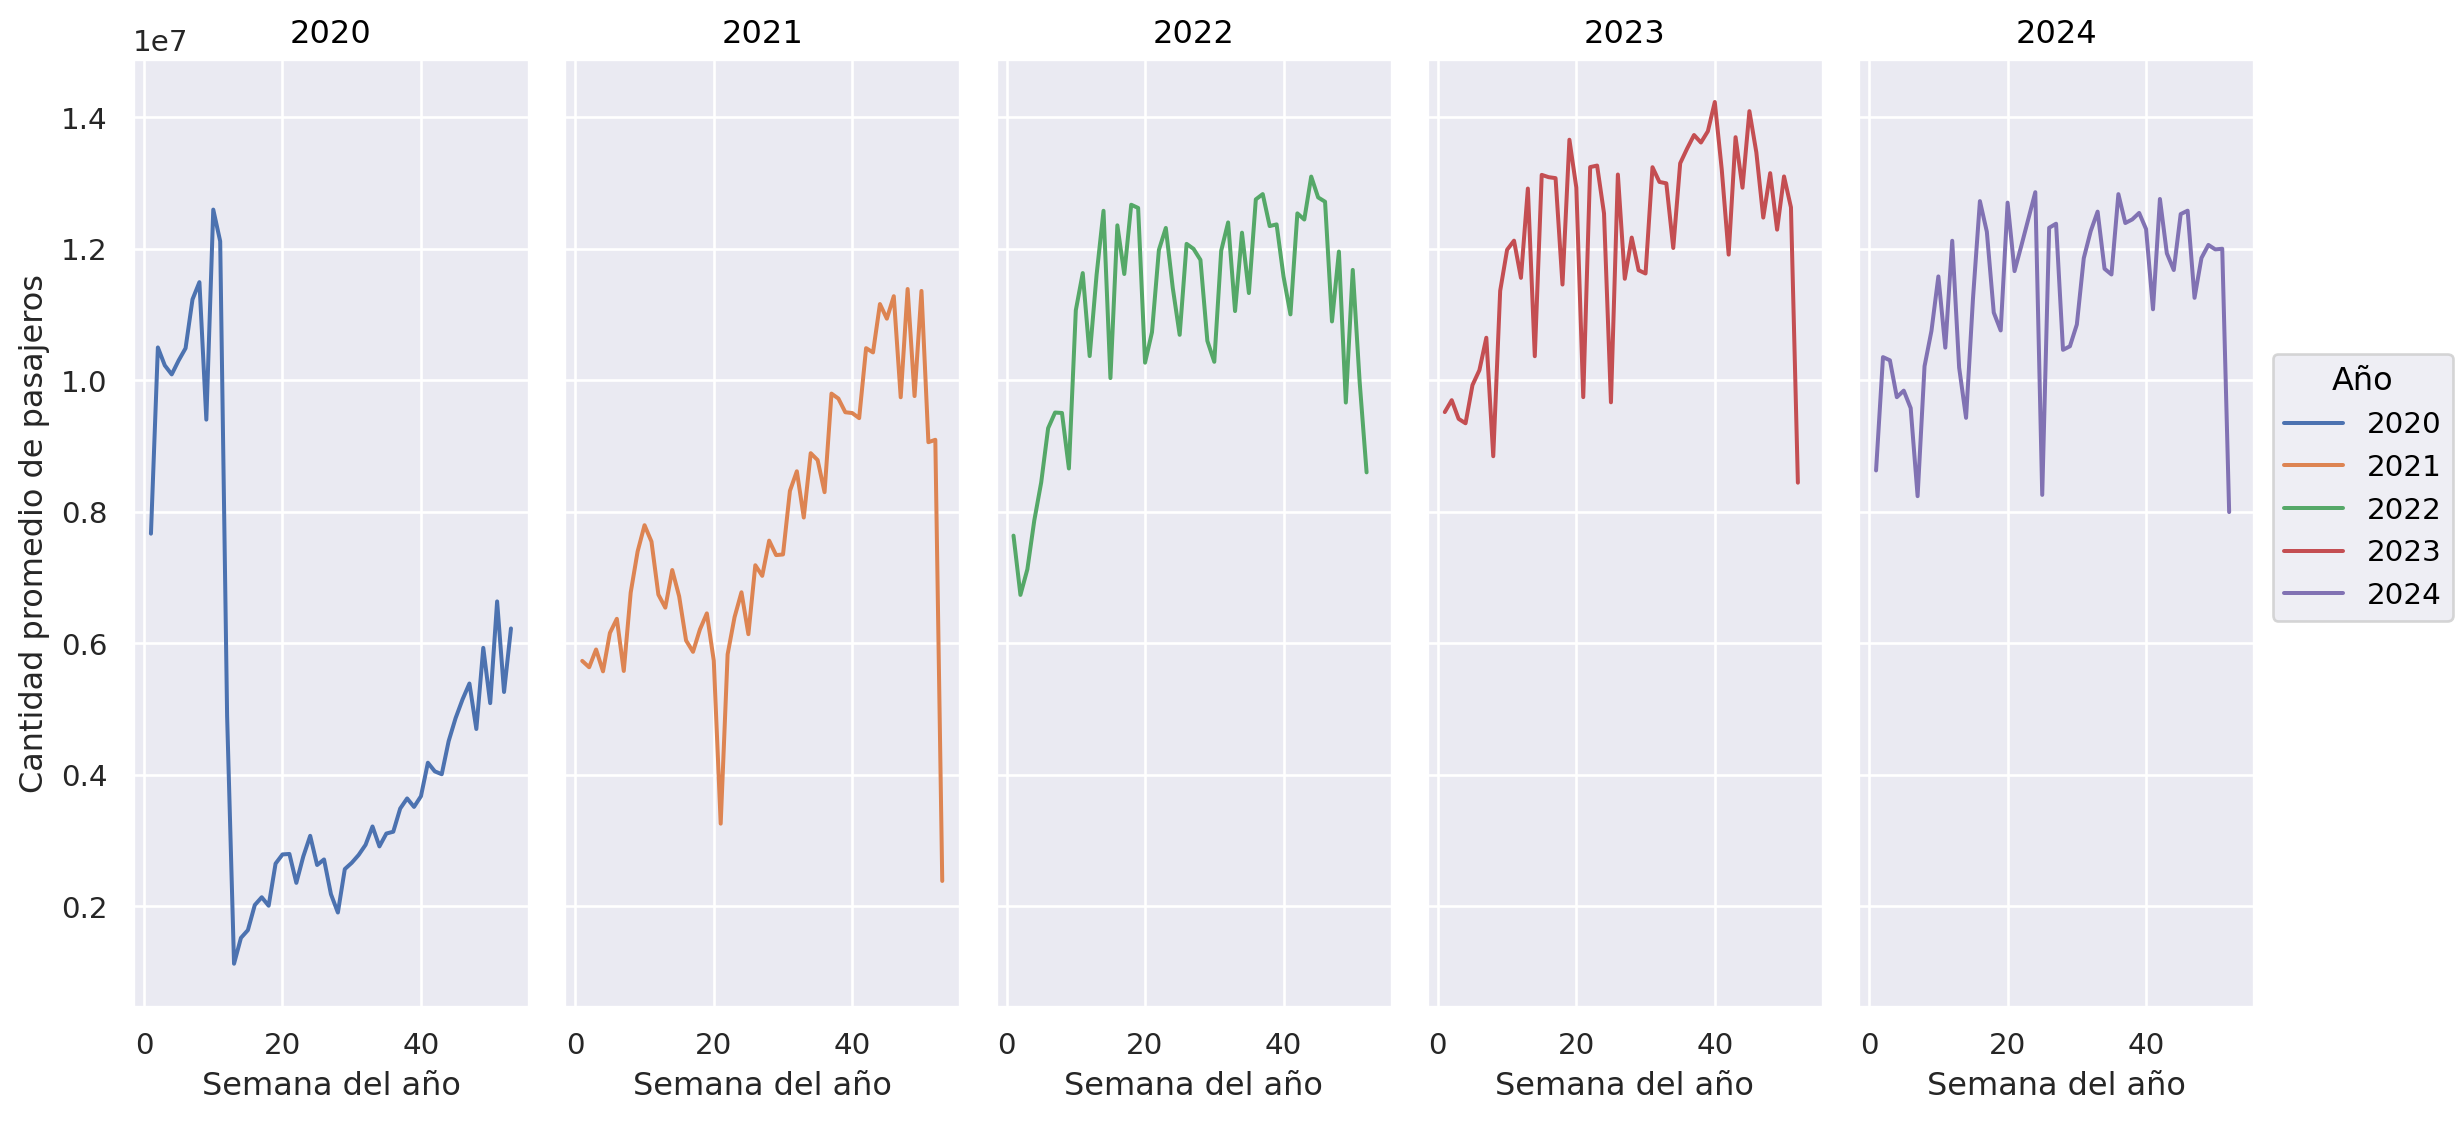

In [32]:
(
    so.Plot(data = cantidad_pasajeros_diarios, x = 'SEMANA_AÑO', y = 'CANTIDAD', color = 'AÑO')
    .add(so.Line(), so.Agg('mean'))
    .facet('AÑO')
    .label(x = "Semana del año", y = "Cantidad promedio de pasajeros", color = "Año")
    .layout(size=(12,6))
)

Podemos observar cómo en las primeras semanas del año 2020, la cantidad de pasajeros desciende drásticamente.

Veamos cómo la explicación de este fenómeno está dada por la pandemia de Covid-19.

Añadimos los datos de casos de covid

In [33]:
datos_covid = pd.read_csv("data/datosCovid.csv")
datos_covid.head()

,fecha,fallecidos,casos_dx
0,2020-01-01,0,35
1,2020-01-02,0,14
2,2020-01-03,0,3
3,2020-01-04,0,7
4,2020-01-05,0,5


Transformamos la columna fecha a tipo de dato datetime y agregamos las columnas año y semana:

In [34]:
datos_covid["fecha"] = pd.to_datetime(datos_covid["fecha"], format = "%Y-%m-%d")
datos_covid["año"] = datos_covid["fecha"].dt.year
datos_covid["semana_año"] = datos_covid["fecha"].dt.isocalendar().week
datos_covid.head()

,fecha,fallecidos,casos_dx,año,semana_año
0,2020-01-01,0,35,2020,1
1,2020-01-02,0,14,2020,1
2,2020-01-03,0,3,2020,1
3,2020-01-04,0,7,2020,1
4,2020-01-05,0,5,2020,1


Restrinjimos los datos a 2020 y 2021, ya que según lo observado en el gráfico, son los dos años que tuvieron un uso disminuido del transporte público

In [35]:
cantidad_pasajeros_diarios_2020_2021 = cantidad_pasajeros_diarios[cantidad_pasajeros_diarios["AÑO"].astype(int) < 2022]
datos_covid_2020_2021 = datos_covid[datos_covid["año"] < 2022]

Vamos a hacer una comparación gráfica, pero como vamos a trabajar con magnitudes distintas, necesitamos escalar los datos, a fin de poder comparar las curvas.

In [36]:
# Para poder comparar las curvas, escalamos los datos
datos_covid_2020_2021["casos_dx_scaled"] = ((datos_covid_2020_2021["casos_dx"] - datos_covid_2020_2021["casos_dx"].min()) / 
                                            (datos_covid_2020_2021["casos_dx"].max() - datos_covid_2020_2021["casos_dx"].min()))

cantidad_pasajeros_diarios_2020_2021["CANTIDAD_scaled"] = ((cantidad_pasajeros_diarios_2020_2021["CANTIDAD"] - cantidad_pasajeros_diarios_2020_2021["CANTIDAD"].min()) / 
                                                           (cantidad_pasajeros_diarios_2020_2021["CANTIDAD"].max() - cantidad_pasajeros_diarios_2020_2021["CANTIDAD"].min()))

/tmp/ipykernel_8228/4152362270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_covid_2020_2021["casos_dx_scaled"] = ((datos_covid_2020_2021["casos_dx"] - datos_covid_2020_2021["casos_dx"].min()) /
/tmp/ipykernel_8228/4152362270.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cantidad_pasajeros_diarios_2020_2021["CANTIDAD_scaled"] = ((cantidad_pasajeros_diarios_2020_2021["CANTIDAD"] - cantidad_pasajeros_diarios_2020_2021["CANTIDAD"].min()) /


Ahora si, comparamos gráficamente:

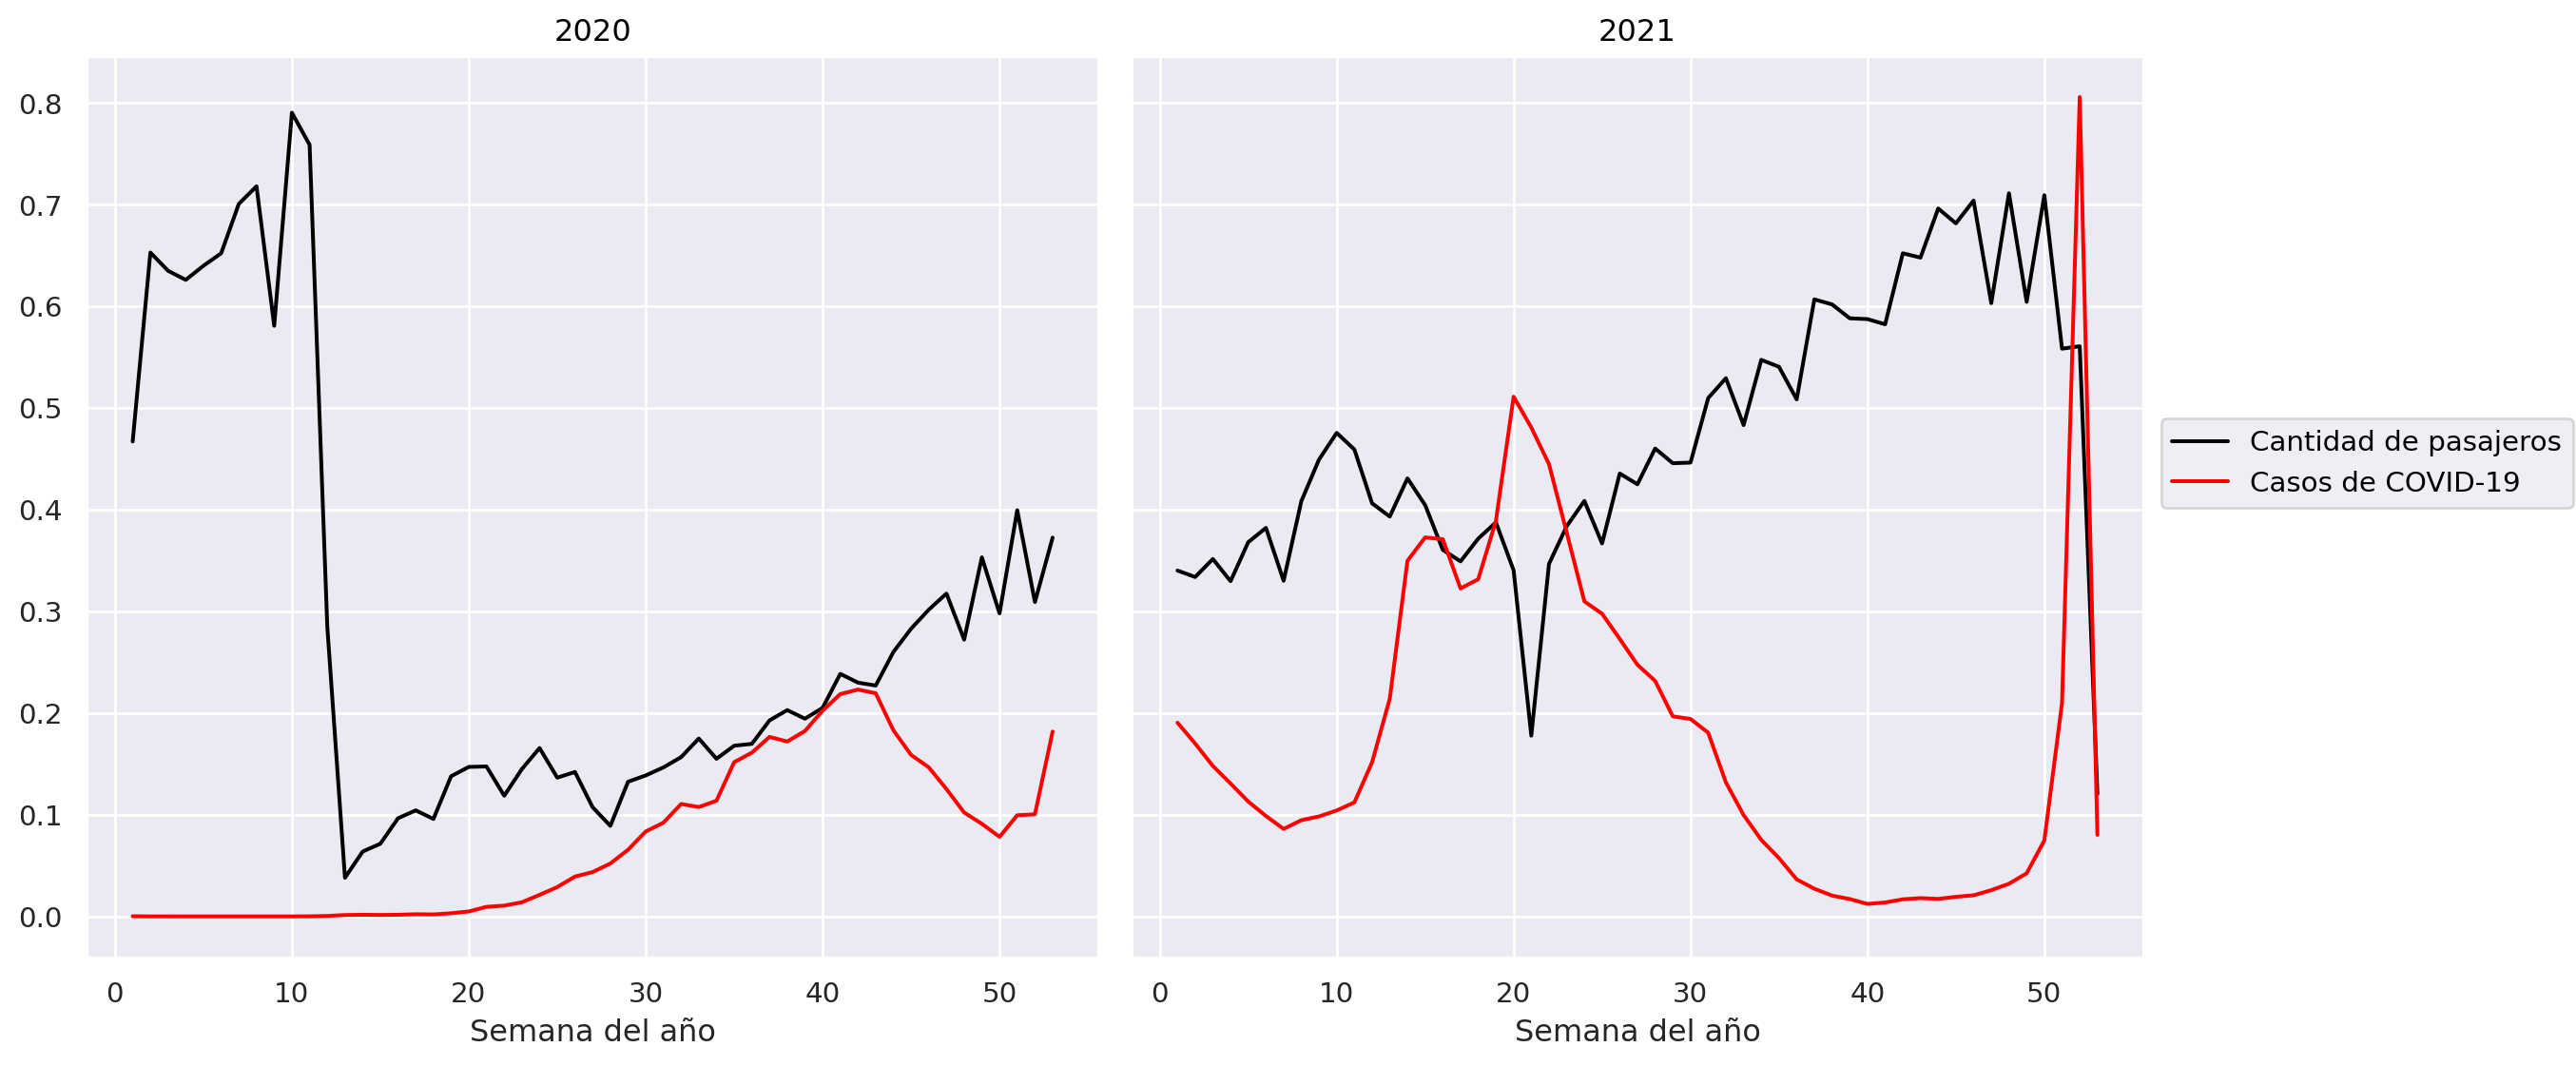

In [37]:
(
    so.Plot(data = cantidad_pasajeros_diarios_2020_2021, x = "SEMANA_AÑO", y = "CANTIDAD_scaled")
    .add(so.Line(color = "black"), so.Agg("mean"), label = 'Cantidad de pasajeros')
    .add(so.Line(color = "red"), so.Agg("mean"), data = datos_covid_2020_2021, x = "semana_año", y = "casos_dx_scaled", label = 'Casos de COVID-19')
    .facet("AÑO")
    .layout(size = (12,6))
    .label(x = "Semana del año", y = "")
)

En primer lugar, si bien la reducción drástica en la cantidad de pasajeros no coincide con un pico en la cantidad de casos, podemos observar que se situa a medidados de marzo, fecha en la cual el servicio de transporte público se limitó al uso del personal esencial.

La notable reducción en la cantidad de pasajeros que se observaba a medidados de 2021, coincide con un pico de casos de Covid. Luego de eso, los casos descienden de manera notable, y en consecuencia, la cantidad de pasajeros aumenta. Es en esa época del año, cuando se comienza a vacunar a la población de manera masiva.

A partir de ese punto, hasta las últimas semanas del año, las curvas están casi espejadas.

Podemos concluir, a partir de ambas visualizaciones, que la flexibilización en las medidas de cuidado frente al virus, se relacionan directamente con el aumento del uso del transporte público.

##### ¿Cuál es el rol de las vacaciones de verano en la variación del uso del transporte público?

Si graficamos la cantidad total de usuarios en el país, para cada mes, podemos observar que en enero y febrero, el número es menor a comparación del resto del año

In [38]:
# Agregamos columnas al dataset original

sube_2024["MES"] = sube_2024["DIA_TRANSPORTE"].dt.month_name().str.slice(0,3)
sube_2024["SEMANA_AÑO"] = sube_2024["DIA_TRANSPORTE"].dt.strftime("%U").astype(int)
sube_2024["CANTIDAD_PROMEDIO_SEMANA"] = sube_2024.groupby("SEMANA_AÑO")["CANTIDAD"].transform("mean")

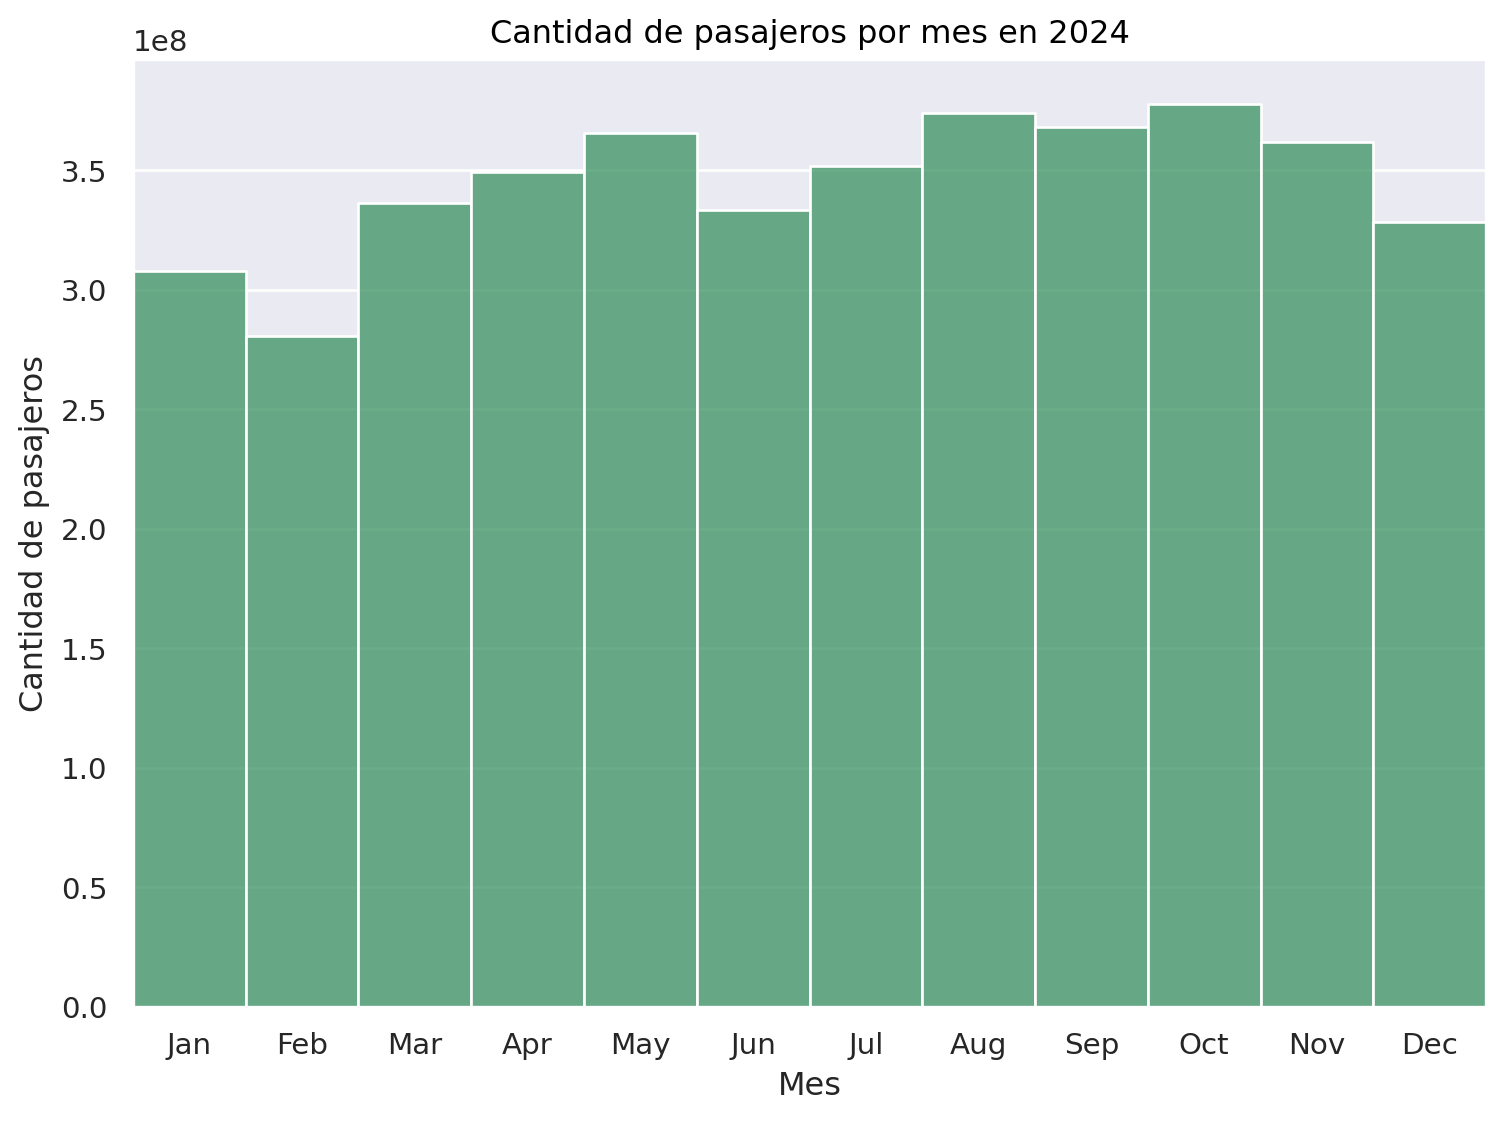

In [39]:
(
    so.Plot(data = sube_2024, x = "MES", y = "CANTIDAD")
    .add(so.Bars(color = "seagreen"), so.Agg("sum"))
    .layout(size=(8,6))
    .label(x = "Mes", y = "Cantidad de pasajeros", title = "Cantidad de pasajeros por mes en 2024")
)

Pero, ¿es así en todo el país? Veamos qué pasa en el destino turistico más elegido: la Costa 🏖️

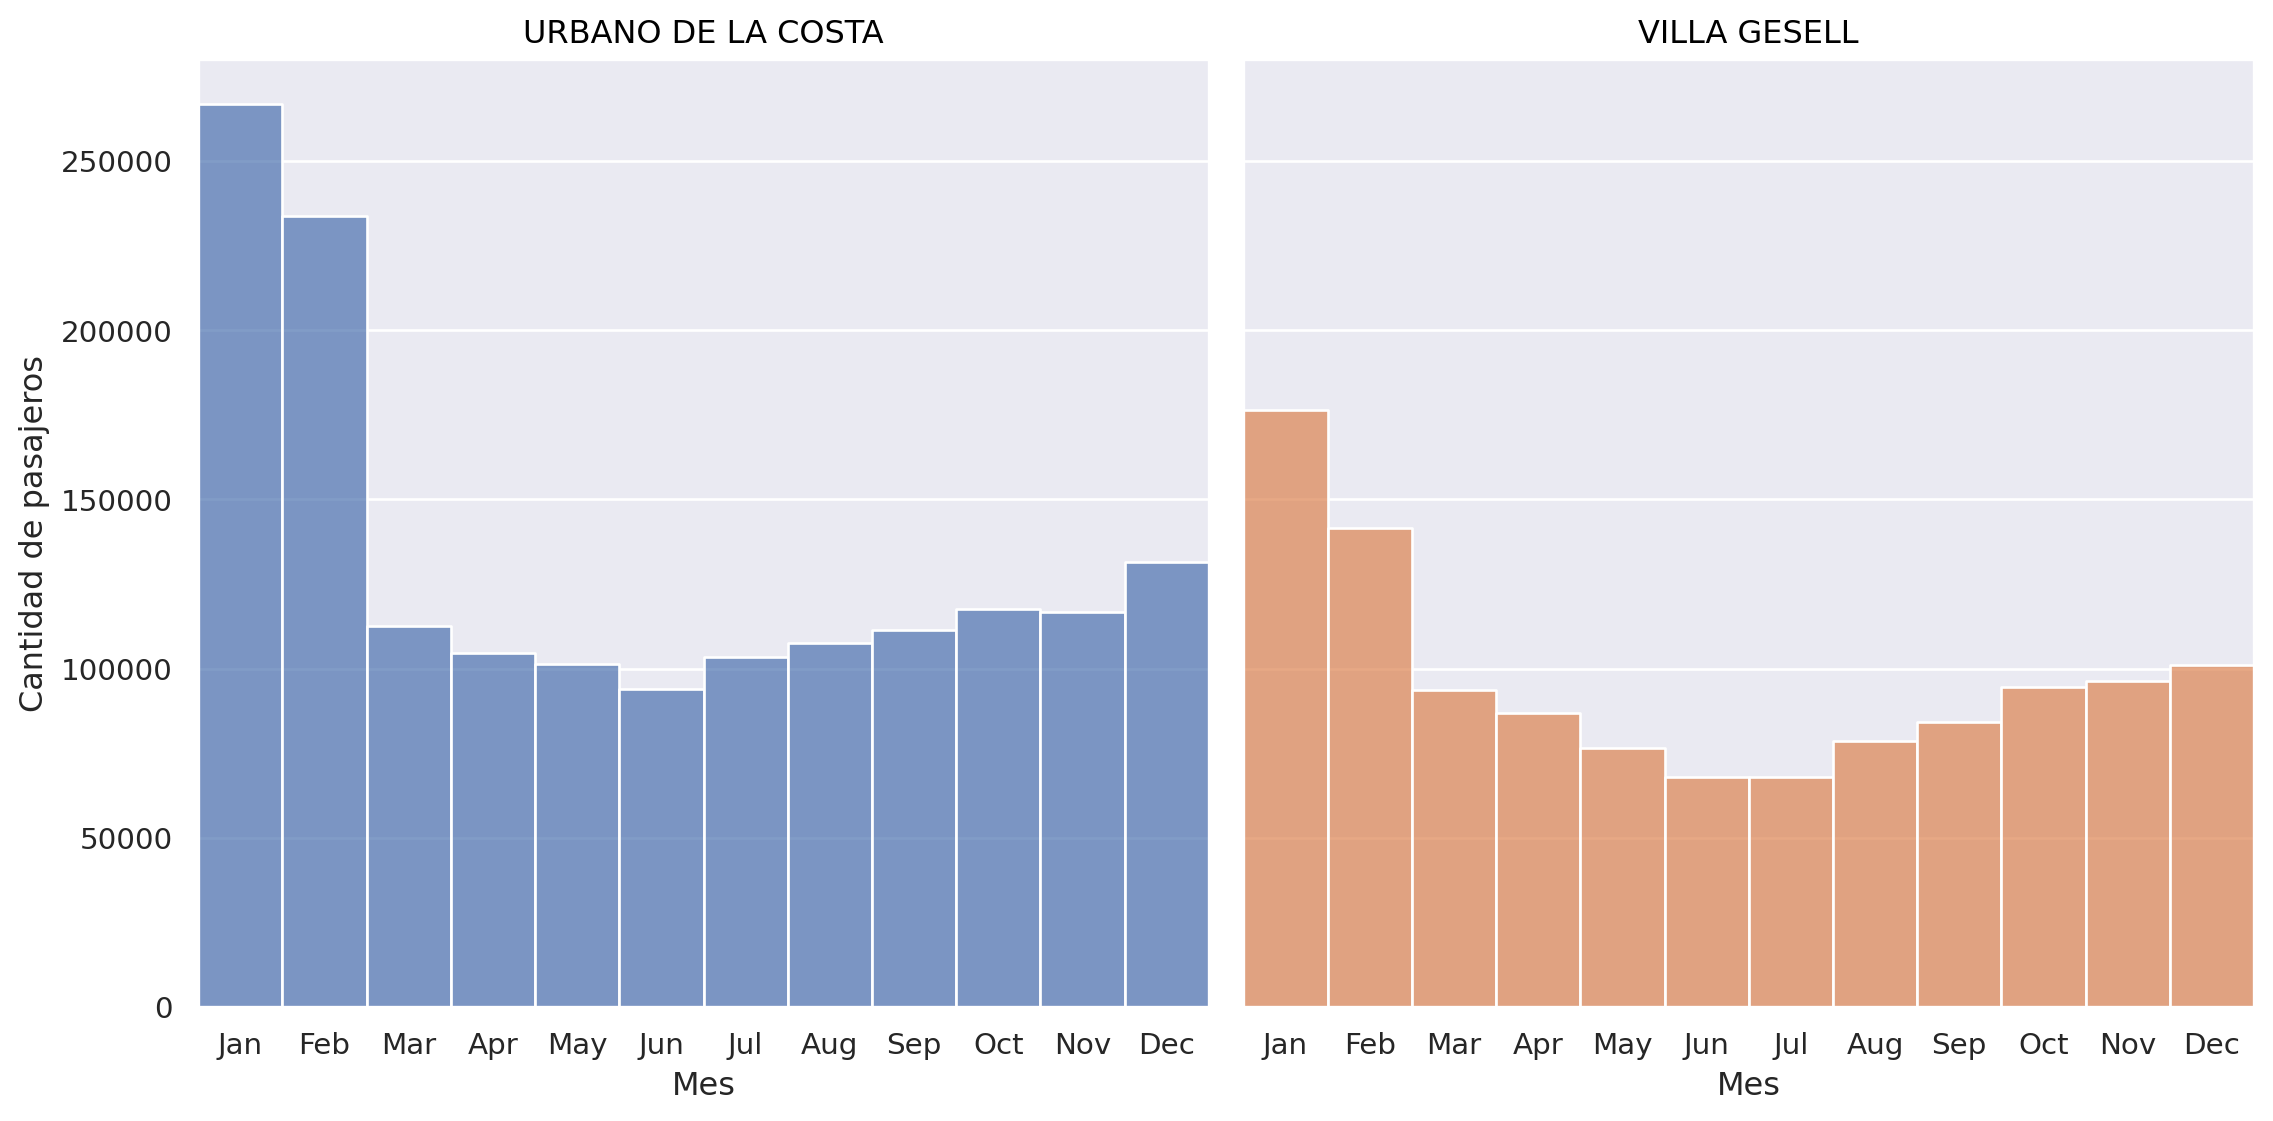

In [40]:
(
    so.Plot(data = sube_2024[sube_2024["MUNICIPIO"].isin(["URBANO DE LA COSTA","VILLA GESELL"])], x = "MES", y = "CANTIDAD")
    .add(so.Bars(), so.Agg("sum"), color = "MUNICIPIO", legend = False)
    .layout(size=(12,6))
    .facet("MUNICIPIO")
    .label(x = "Mes", y = "Cantidad de pasajeros")
)

Claramente, sucede lo contrario.

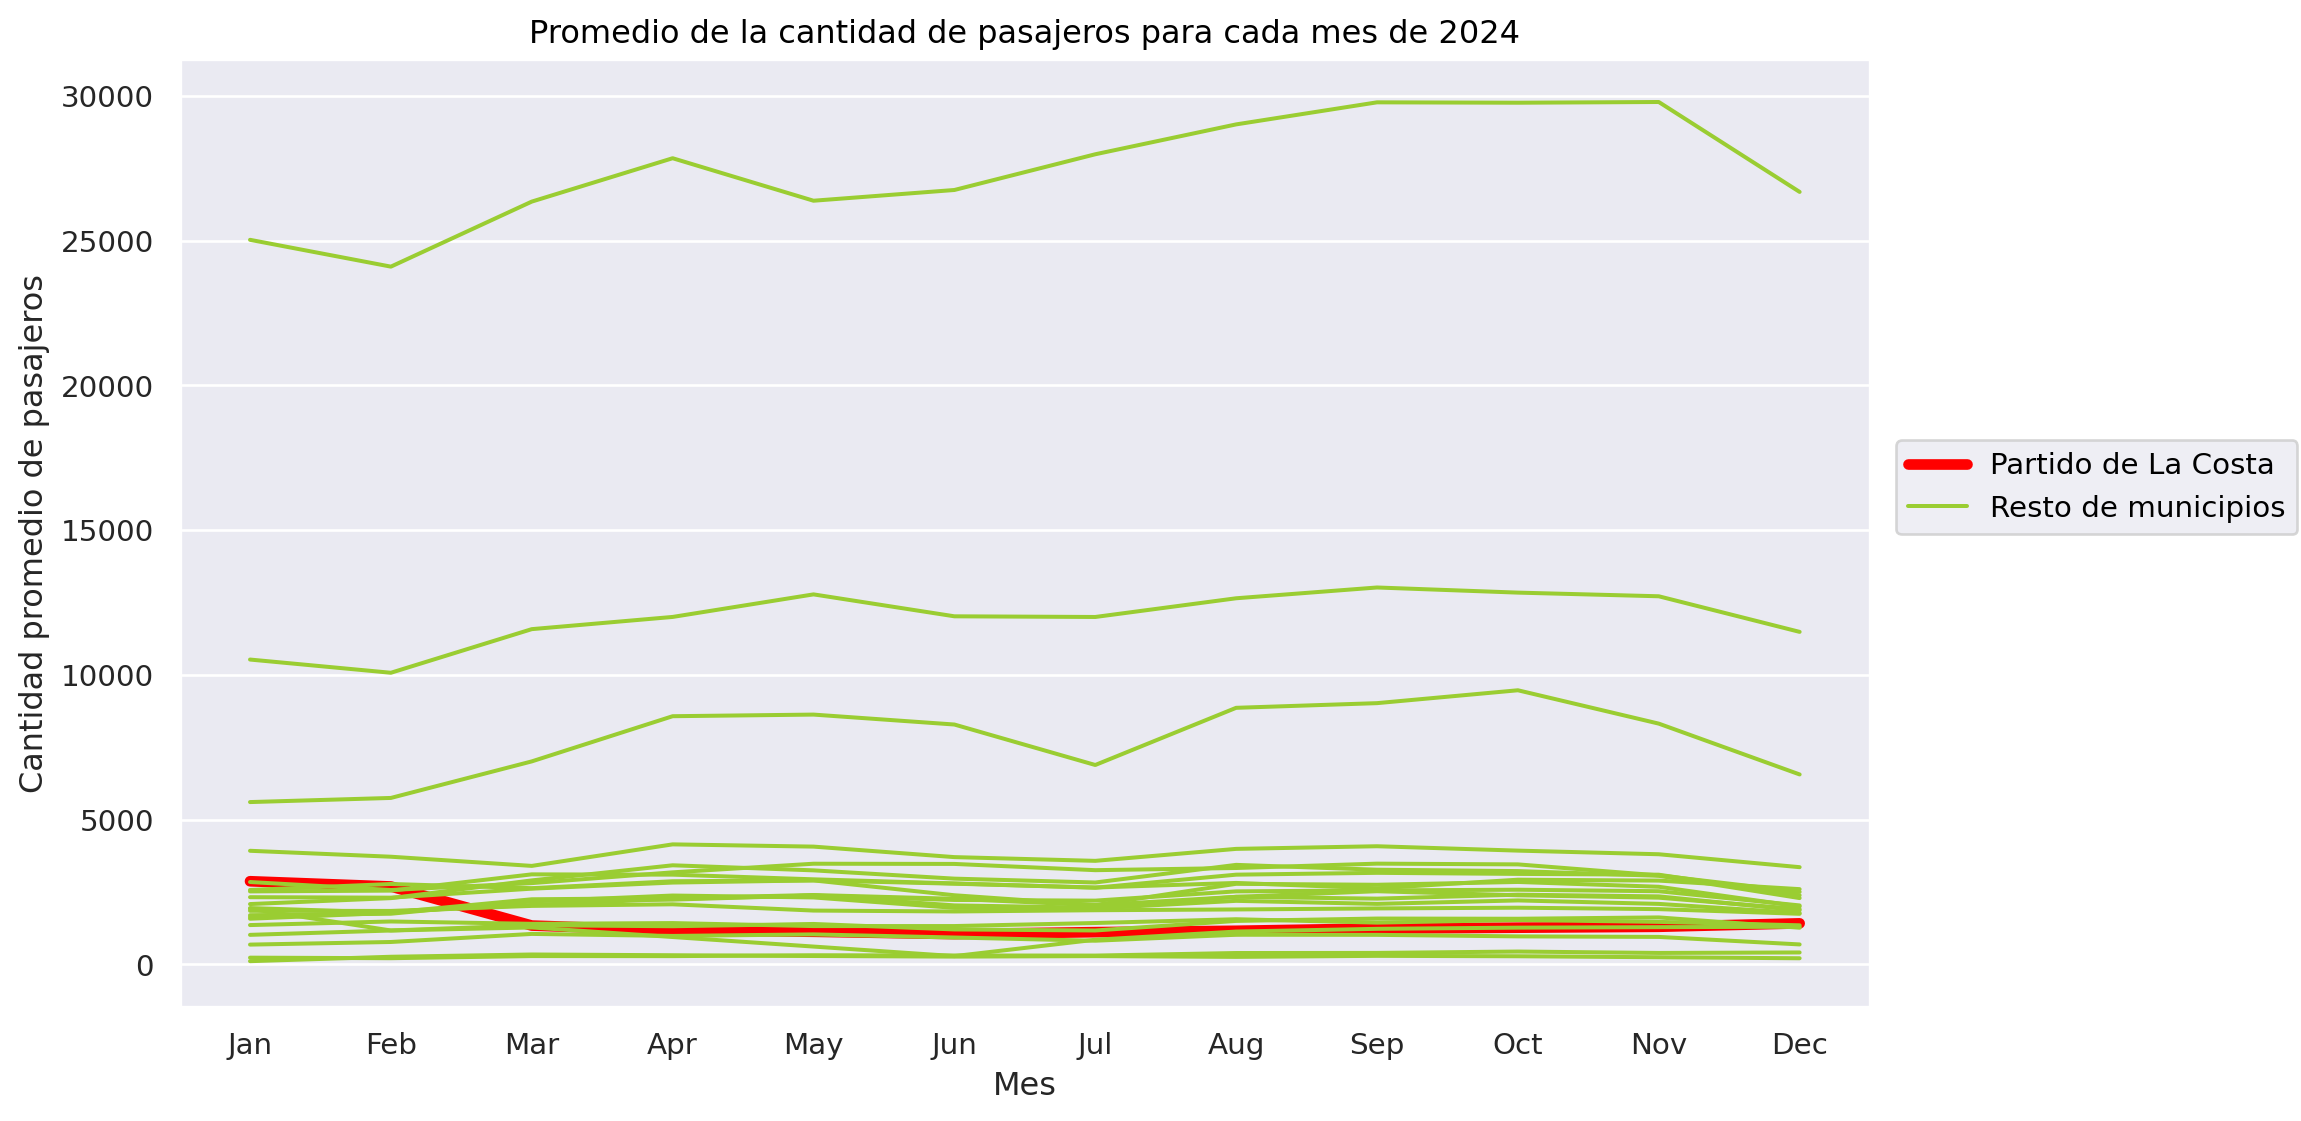

In [41]:
(
    so.Plot(data = sube_2024[(sube_2024["MUNICIPIO"] != "URBANO DE LA COSTA")], x = "MES", y = "CANTIDAD")
    .add(so.Line(color = "red", linewidth=4), so.Agg("mean"), data = sube_2024[sube_2024["MUNICIPIO"] == "URBANO DE LA COSTA"], label = 'Partido de La Costa')
    .add(so.Line(color = "yellowgreen"),so.Agg("mean"), group = "PROVINCIA", label = 'Resto de municipios')
    .label(x = "Mes", y = "Cantidad promedio de pasajeros", title = "Promedio de la cantidad de pasajeros para cada mes de 2024")
    .layout(size=(10,6))
)

Mientras que en el resto del país, la actividad es menor, la Costa alcanza su pico de pasajeros.

##### ¿Cuánto varía la cantidad de pasajeros en cada día de la semana?

Primero agregamos la columna día y el total diario:

In [42]:
dias_orden = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
sube_2024["DIA"] = pd.Categorical(sube_2024["DIA_TRANSPORTE"].dt.day_name(), categories = dias_orden, ordered = True)
sube_2024["CANTIDAD_TOTAL_DIA"] = sube_2024.groupby(["DIA_TRANSPORTE"])["CANTIDAD"].transform("sum")

Graficamos:

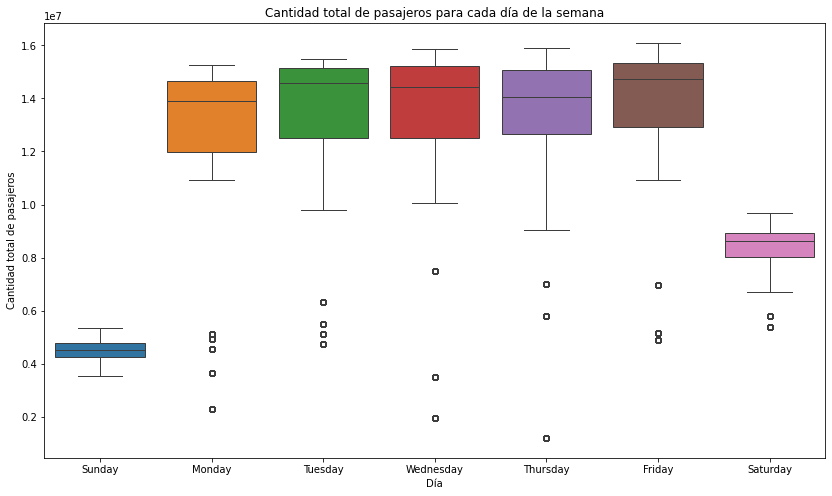

In [43]:
# Graficamos
plt.figure(figsize=(14,8))
sns.boxplot(data = sube_2024, x = "DIA", y = "CANTIDAD_TOTAL_DIA", hue = "DIA")
plt.xlabel("Día")
plt.ylabel("Cantidad total de pasajeros")
plt.title("Cantidad total de pasajeros para cada día de la semana")
plt.show()

De este gráfico, podemos concluir que los días sábado y domingo, son aquellos con menor cantidad de pasajeros, y los que menos varían.

Los días hábiles, siguen todos un esquema similar, siendo el día jueves aquel que más varía respecto a esta cantidad.

Veremos en lo siguiente, que pueden representar los outliers del gráfico.

##### ¿Cuál es el efecto de los feriados en la actividad del transporte público? ¿Y los paros?

Veamos el caso del subte

In [44]:
# Agregamos la columna Promedio diario
sube_2024["CANTIDAD_PROMEDIO_DIARIO"] = sube_2024.groupby(["DIA_TRANSPORTE","TIPO_TRANSPORTE"])["CANTIDAD"].transform("mean")

Indagamos y registramos en una Serie de Pandas los feriados y paros del servicio de subte en 2024

In [45]:
feriados = pd.to_datetime(pd.Series(["2024-01-01","2024-02-12","2024-02-13","2024-03-24","2024-03-28","2024-03-29","2024-04-01",
                                     "2024-04-02","2024-05-01","2024-05-25","2024-06-17","2024-06-20","2024-06-21","2024-07-09",
                                     "2024-08-17","2024-10-11","2024-10-12","2024-11-18","2024-12-08","2024-12-15"]))

paros = pd.to_datetime(pd.Series(["2024-01-24","2024-05-09","2024-06-19","2024-07-05","2024-11-20"]))

Grafiquemos estas fechas junto a la cantidad promedio de pasajeros por cada día

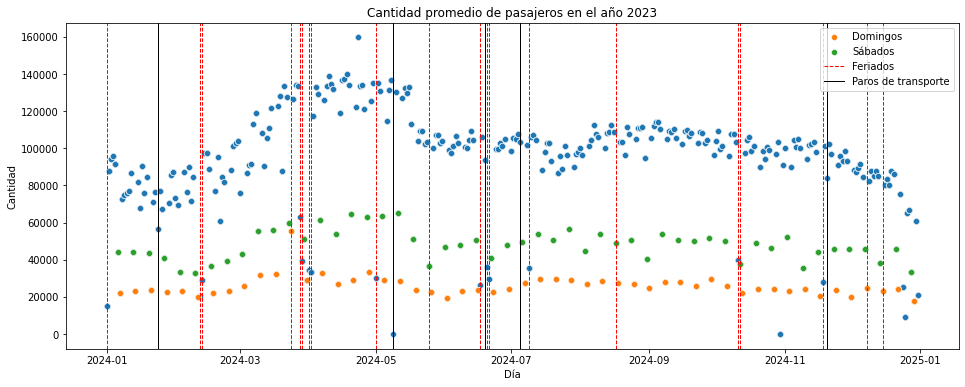

In [46]:
plt.figure(figsize = (16,6))
sns.scatterplot(data = sube_2024[sube_2024["TIPO_TRANSPORTE"] == "SUBTE"], x = "DIA_TRANSPORTE", y = "CANTIDAD_PROMEDIO_DIARIO")
sns.scatterplot(data = sube_2024[(sube_2024["TIPO_TRANSPORTE"] == "SUBTE") & (sube_2024["DIA"] == "Sunday")], x = "DIA_TRANSPORTE", y = "CANTIDAD_PROMEDIO_DIARIO", label = "Domingos")
sns.scatterplot(data = sube_2024[(sube_2024["TIPO_TRANSPORTE"] == "SUBTE") & (sube_2024["DIA"] == "Saturday")], x = "DIA_TRANSPORTE", y = "CANTIDAD_PROMEDIO_DIARIO", label = "Sábados")
# Marcamos los feriados
plt.axvline(x = feriados[0], color = "red", linestyle = "--", linewidth = 1, label = "Feriados")
for feriado in feriados[1:]:
    plt.axvline(x = feriado, color = "red", linestyle = "--", linewidth = 1)
plt.axvline(x = paros[0], color = "black", linewidth = 1, label = "Paros de transporte")
for paro in paros[1:]:
    plt.axvline(x = paro, color = "black", linewidth = 1)
plt.xlabel("Día")
plt.ylabel("Cantidad")
plt.title("Cantidad promedio de pasajeros en el año 2023")
plt.legend()
plt.show()

Podemos concluir, viendo el gráfico, que los outliers, especialmente cuando se tratan de días de semana, están explicados por los feriados y los paros de transporte ocurridos a lo largo del año.

Se observa que algunos días de paro tienen mayor cantidad de pasajeros que otros. Esto se debe a que no todas las lineas se ahirieron a algunos de ellos, y los paros, en su mayoría, eran durante un lapso breve de tiempo, de aproximadamente 2~3 horas.

##
***

## Modelado

### Ejercicio 5

En este ítem, vamos a ajustar la cantidad de pasajeros que viajan por día en una línea de colectivos, utilizando la información de pasajeros por día de otras líneas.

In [47]:
# Volvemos a cargar el DataFrame para trabajar con la configuración original
sube = pd.read_csv('data/sube-2024.csv')
sube['DIA_TRANSPORTE'] = pd.to_datetime(sube['DIA_TRANSPORTE'], format = "%Y-%m-%d")

$\mathbf{(a)}$ Generar un DataFrame en el que las columnas sean las líneas de colectivo de AMBA de jurisdicción nacional, y las observaciones sean los días del año. Es decir, cada fila del DataFrame corresponde a un día del año, y en esa fila deben figurar la cantidad de pasajeros que viajaron en cada línea de colectivo en el día correspondiente.

In [48]:
#Primero nos quedamos con los datos de AMBA y Jurisdicción Nacional.
datos_colectivoJN = sube[(sube['PROVINCIA'] == 'JN') & (sube['AMBA'] == 'SI')]
columnas = datos_colectivoJN['LINEA'].unique() #Estas van a ser las columnas de nuestro nuevo DF.

#Creamos el DataFrame y agregramos los registros
pasajeros_por_linea = pd.DataFrame()
for col in columnas:
    datos_linea = datos_colectivoJN[datos_colectivoJN['LINEA'] == col][['DIA_TRANSPORTE','CANTIDAD']]
    datos_linea = datos_linea.set_index('DIA_TRANSPORTE').rename(columns = {'CANTIDAD':col})
    pasajeros_por_linea = pd.concat([pasajeros_por_linea, datos_linea], axis = 1)

pasajeros_por_linea.head()


,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA 8160,Linea 8164,Linea 8168,LINEA 8179,Linea 8180,Linea 8188,LINEA 8033,Linea 8143,LINEA 8067,Linea 8129
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2024-01-01,1901,7238,4341,6302,12323,8540,2191,3270,12695,2955,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-02,10228,23818,25495,22960,48899,33503,15107,12086,60633,16201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-03,11292,27187,27341,24672,53389,36225,16861,13615,65844,17958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-04,11846,26954,28190,25402,55860,36969,17450,13836,65974,17994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-05,11963,27913,29696,26327,55536,38926,17181,14255,68506,18997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


$\mathbf{(b)}$ Eliminar las columnas correspondientes a líneas de colectivo que tengan datos faltantes

Utilizamos el comando dropna

In [49]:
pasajeros_por_linea = pasajeros_por_linea.dropna(axis = 1)
pasajeros_por_linea.rename(columns= lambda x: x.replace(' ', '_'), inplace = True)

In [50]:
pasajeros_por_linea.head()

,BS_ASLINEA_123,BSAS_LINEA_002,BSAS_LINEA_009,BSAS_LINEA_010,BSAS_LINEA_015,BSAS_LINEA_017,BSAS_LINEA_019,BSAS_LINEA_020,BSAS_LINEA_021,BSAS_LINEA_022,...,LINEA_33,LINEA_42,LINEA_44,LINEA_50,LINEA_6,LINEA_7,LINEA_76,LINEA_8,LINEA_099,LINEA_164_AMBA
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2024-01-01,1901,7238,4341,6302,12323,8540,2191,3270,12695,2955,...,11267,4834,5636,6284,2533,2553,4956,11020,2545,3643
2024-01-02,10228,23818,25495,22960,48899,33503,15107,12086,60633,16201,...,37926,21500,22074,19421,11598,13993,20770,45177,11644,19765
2024-01-03,11292,27187,27341,24672,53389,36225,16861,13615,65844,17958,...,39075,23829,23989,20951,12964,15205,22699,48589,12848,22512
2024-01-04,11846,26954,28190,25402,55860,36969,17450,13836,65974,17994,...,40369,23575,24418,21088,13405,15832,23969,49832,12986,24134
2024-01-05,11963,27913,29696,26327,55536,38926,17181,14255,68506,18997,...,41225,24470,24903,21712,13720,15457,24809,51945,12651,25223


$\mathbf{(c)}$ Se quiere ajustar la cantidad de pasajeros en la línea BSAS_LINEA_009 en función de los pasajeros en otras líneas. Proponer tres modelos de regresión distintos. En cada modelo, pueden utilizarse la información solo de otras 5 líneas de colectivos (pueden ser distintas líneas de colectivo en los distintos modelos).

En primer lugar, vamos a separar nuestro dataset en dos conjuntos: uno de entrenamiento, y otro de testeo.

In [51]:
sube_train, sube_test = train_test_split(pasajeros_por_linea, test_size = 0.2, random_state = 42)

#### Modelo 1

Para este modelo, vamos a seleccionar cinco líneas de colectivo al azar, y veremos qué sucede.

In [52]:
import random
random.seed(120)
lineasAlAzar = random.sample(pasajeros_por_linea.columns.tolist(), 5)
lineasAlAzar

['BSAS_LINEA_127', 'BSAS_LINEA_067', 'BSAS_LINEA_056', 'LINEA_6', 'LINEA_7']

Utilizaremos la librería Formulaic, la cual nos permitirá escribir la fórmula de nuestro modelo siguiendo la notación de Wilkinson-Rogers.

In [53]:
formula1 = 'BSAS_LINEA_009 ~ BSAS_LINEA_127 + BSAS_LINEA_067 + BSAS_LINEA_056 + LINEA_6 + LINEA_7'
y1, X1 = Formula(formula1).get_model_matrix(sube_train)

Haremos validación cruzada en K-pliegos. Establecemos los pliegos, definimos el modelo y creamos una lista donde almacenaremos los errores cuadráticos medios (ECM) de cada regresión

In [54]:
cv = KFold(n_splits = 5, random_state = 42, shuffle = True)
modeloColectivosAlAzar = linear_model.LinearRegression(fit_intercept = False)
rmse1 = np.zeros(cv.get_n_splits()) #Acá almacenamos la raíz cuadrada del error cuadrático medio
rmod1 = np.zeros(cv.get_n_splits()) #Acá almacenamos el coeficiente de determinación R^2

Hacemos las regresiones para los distintos folds

In [55]:
index = 0
for train_index, val_index in cv.split(X1):
    X_train, X_val, y_train, y_val = X1.iloc[train_index], X1.iloc[val_index], y1.iloc[train_index], y1.iloc[val_index]
    modeloColectivosAlAzar.fit(X_train, y_train)
    y_pred = modeloColectivosAlAzar.predict(X_val)

    #Agregamos las métricas
    rmse1[index] = np.sqrt(mean_squared_error(y_val, y_pred))
    rmod1[index] = r2_score(y_val, y_pred)

    index += 1

Y los resultados obtenidos son los siguientes:

In [56]:
print('Promedio de la raiz cuadarada del ECM del modelo 1: ', rmse1.mean())
print('Promedio de los R² del modelo 1: ',rmod1.mean())

Promedio de la raiz cuadarada del ECM del modelo 1:  1855.1052765447766
Promedio de los R² del modelo 1:  0.9650593392798553


Bajo estas dos métricas podemos afirmar que la predicción es bastante acertada, pero se puede mejorar...

#### Modelo 2

Para este modelo, elegimos a mano algunas líneas que tengan recorridos similares a la línea 9, o que en su trayecto atraviesen puntos muy transitados en común con dicha línea, para poder hacernos una idea más fiel de cuántos pasajeros la utilizan.

Las líneas que elegimos son:

- BSAS_LINEA_020
- BSAS_LINEA_100
- BSAS_LINEA_067
- BSAS_LINEA_188
- BSAS_LINEA_045
- BSAS_LINEA_134
- LINEA_164_AMBA
- BSAS_LINEA_070

De las ocho líneas, creamos todas las posibles fórmulas que contengan cinco de ellas, con y sin intercept.

In [57]:
from itertools import combinations

nombres_lineas = ['BSAS_LINEA_020','BSAS_LINEA_100','BSAS_LINEA_067','BSAS_LINEA_188',
                  'BSAS_LINEA_045','BSAS_LINEA_134','LINEA_164_AMBA','BSAS_LINEA_070']

grupos_cinco = list(combinations(nombres_lineas, 5))

#Creamos todas las fórmulas posibles
formulas = []
for g in grupos_cinco:
    formulas.append(f'BSAS_LINEA_009 ~ {g[0]} + {g[1]} + {g[2]} + {g[3]} + {g[4]} - 1') #Sin intercept
    formulas.append(f'BSAS_LINEA_009 ~ {g[0]} + {g[1]} + {g[2]} + {g[3]} + {g[4]}') #Con intercept

Ahora realizamos la regresión con cada una de las fórmulas, almacenando los ECM en una lista, y luego devolvemos el menor de ellos.

In [58]:
ECMS = [] #Acá vamos a guardar el ECM asociado a cada fórmula
index = 0

for f in formulas:
    y2,X2 = Formula(f).get_model_matrix(sube_train)

    cv = KFold(n_splits = 5, random_state = 42, shuffle = True)

    #Creamos el modelo
    modelo2 = linear_model.LinearRegression(fit_intercept = False)
    rmse2 = np.zeros(cv.get_n_splits())

    ind = 0

    #Hacemos K-Fold Validation
    for train_index, val_index in cv.split(X2):
        X_train, X_val, y_train, y_val = X2.iloc[train_index], X2.iloc[val_index], y2.iloc[train_index], y2.iloc[val_index]
        modelo2.fit(X_train, y_train)

        y_pred = modelo2.predict(X_val)
        rmse2[ind] = np.sqrt(mean_squared_error(y_val, y_pred))

        ind += 1
        index += 1
    
    ECMS.append(rmse2.mean())

min_index = ECMS.index(min(ECMS))

Y obtenemos los siguientes resultados:

In [59]:
print(f'Min ECM conseguido: {ECMS[min_index]}')
print(f'Formula que se usó: {formulas[min_index]}')

Min ECM conseguido: 1514.7820933342898
Formula que se usó: BSAS_LINEA_009 ~ BSAS_LINEA_020 + BSAS_LINEA_100 + BSAS_LINEA_045 + LINEA_164_AMBA + BSAS_LINEA_070 - 1


Ahora, realizamos nuevamente la regresión pero esta vez usando la combinación de colectivos que nos dió el mejor resultado.

In [60]:
formula2 = formulas[min_index]
y2, X2 = Formula(formula2).get_model_matrix(sube_train)

Establecemos los folds, definimos el modelo y almacenamos los ECM de cada regresión

In [61]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
modelo2 = linear_model.LinearRegression(fit_intercept = False)
rmse2 = np.zeros(cv.get_n_splits())
rmod2 = np.zeros(cv.get_n_splits())

Hacemos las regresiones para los distintos folds

In [62]:
index = 0

for train_index, val_index in cv.split(X2):
    X_train, X_val, y_train, y_val = X2.iloc[train_index], X2.iloc[val_index], y2.iloc[train_index], y2.iloc[val_index]
    modelo2.fit(X_train, y_train)

    y_pred = modelo2.predict(X_val)
    rmse2[index] = np.sqrt(mean_squared_error(y_val, y_pred))
    rmod2[index] = r2_score(y_val, y_pred)
    
    index += 1

Y obtenemos los siguientes resultados:

In [63]:
print('Promedio de la raiz cuadarada del ECM del modelo 2: ',rmse2.mean())
print('Promedio de los R² del modelo 2: ',rmod2.mean())

Promedio de la raiz cuadarada del ECM del modelo 2:  1514.7820933342898
Promedio de los R² del modelo 2:  0.9772814048687103


Ambas métricas mejoraron respecto al modelo anterior, así que parece haber funcionado la elección de líneas.

#### Modelo 3

Ahora, utilizaremos un modelo de regresión Ridge.

In [64]:
formula3 = 'BSAS_LINEA_009 ~ (BSAS_LINEA_020 + BSAS_LINEA_067 + BSAS_LINEA_188 + BSAS_LINEA_134 + LINEA_164_AMBA)*(BSAS_LINEA_020 + BSAS_LINEA_067 + BSAS_LINEA_188 + BSAS_LINEA_134 + LINEA_164_AMBA)-1'
y3, X3 = Formula(formula3).get_model_matrix(sube_train)

#Escalamos los datos de la matriz X3
X3 = (X3 - X3.min()) / (X3.max() - X3.min())

Creamos una lista con los valores $\alpha$ que vamos a usar para penalizar los coeficientes altos.

In [65]:
alphas = np.arange(0,0.01,0.0001)

In [66]:
cv = KFold(n_splits = 5, random_state = 73, shuffle = True)
min_ecm = 10**10
alpha_min = 0

for alpha in alphas:
    modeloRidge = linear_model.Ridge(alpha = alpha, fit_intercept = False)
    rmse3 = np.zeros(cv.get_n_splits())
    index = 0

    for train_index, val_index in cv.split(X3):
        X_train, X_val, y_train, y_val = X3.iloc[train_index], X3.iloc[val_index], y3.iloc[train_index], y3.iloc[val_index]
        modeloRidge.fit(X_train, y_train)

        y_pred = modeloRidge.predict(X_val)
        rmse3[index] = np.sqrt(mean_squared_error(y_val, y_pred))
        index += 1

    # Actualizamos el valor óptimo de Alpha
    if rmse3.mean() < min_ecm:
        min_ecm = rmse3.mean()
        alpha_min = alpha

Y obtenemos lo siguiente:

In [67]:
print(f'Mínimo ECM conseguido: {min_ecm}')
print(f'Alpha que lo consiguió: {alpha_min}')

Mínimo ECM conseguido: 1871.0105773155742
Alpha que lo consiguió: 0.0099


Ahora, con el valor alpha definido, hacemos la regresión una vez más.

In [68]:
modeloRidge = linear_model.Ridge(alpha = alpha_min, fit_intercept = False)
rmse3 = np.zeros(cv.get_n_splits())
rmod3 = np.zeros(cv.get_n_splits())

index = 0
y_pred = 0
y_val = 0

for train_index, val_index in cv.split(X3):
    X_train, X_val, y_train, y_val = X3.iloc[train_index], X3.iloc[val_index], y3.iloc[train_index], y3.iloc[val_index]
    modeloRidge.fit(X_train, y_train)

    y_pred = modeloRidge.predict(X_val)
    rmse3[index] = np.sqrt(mean_squared_error(y_val, y_pred))
    rmod3[index] = r2_score(y_val, y_pred)

    index += 1

Los resultados obtenidos son los siguientes:

In [69]:
print('Promedio de la raíz cuadarada del modelo Ridge: ', rmse3.mean())
print('Promedio de los R² del modelo Ridge: ',rmod3.mean())

Promedio de la raíz cuadarada del modelo Ridge:  1871.0105773155742
Promedio de los R² del modelo Ridge:  0.9645050953911817


Este método no logró mejorar los resultados conseguidos con el método 2.

#### Conclusión

Pudimos analizar cada modelo, y el que mejor aproxima los datos es el número 2.


Calculemos las métricas y grafiquemos:

In [70]:
y_test, X_test = Formula(formula2).get_model_matrix(sube_test)
y_pred = modelo2.predict(X_test)

r2 = r2_score(y_test, y_pred)
print('Coeficiente de determinación R²: ', r2)
ecm = mean_squared_error(y_test, y_pred)
print('Raiz cuadrada del error cuadrático medio: ', np.sqrt(ecm))
plt.show()

Coeficiente de determinación R²:  0.9537509199236952
Raiz cuadrada del error cuadrático medio:  1880.2947313086795


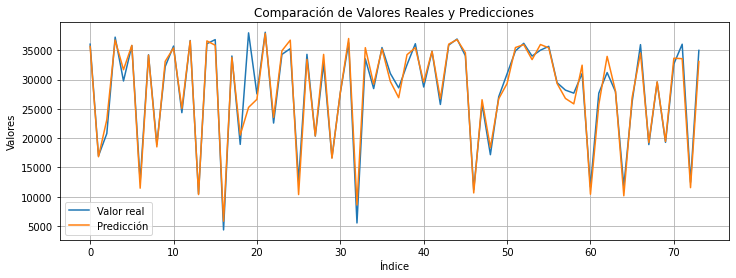

In [71]:
plt.figure(figsize=(12, 4))
plt.plot(np.arange(0,len(y_test)),y_test, label="Valor real")
plt.plot(np.arange(0,len(y_pred)),y_pred, label="Predicción")
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Comparación de Valores Reales y Predicciones')
plt.legend()
plt.grid()